# Aarav Nigam
# Trading Model (RL Model)

## Importing Libraries


In [1]:
!pip install torch=='2.2.2'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from collections import deque
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


## Defining Variables



In [30]:
path='./DATA/data.csv'

# Define hyperparameters
output_size = 3
window_size = 20  # Number of days to consider as a window
input_size = 18*window_size  # Features per day are




In [52]:
np.random.seed(28)
torch.manual_seed(28)
torch.cuda.manual_seed(28)

In [53]:
# Define different sets of hyperparameters for each agent
agents_params = [
    {'hidden_size1': 512, 'hidden_size2': 128, 'learning_rate': 0.001,'gamma':0.99, 'epsilon_start': 0.99,'epsilon_end':0.001,'epsilon_decay':0.9999,'episodes':8,'batch_size':64,'update_freq':20,'update_upperBound':150},
    {'hidden_size1': 256, 'hidden_size2': 64, 'learning_rate': 0.0005, 'gamma':0.95, 'epsilon_start': 0.95,'epsilon_end':0.001,'epsilon_decay':0.9995,'episodes':8,'batch_size':128,'update_freq':20,'update_upperBound':200},
    {'hidden_size1': 512, 'hidden_size2': 128, 'learning_rate': 0.0001, 'gamma':0.99, 'epsilon_start': 1,'epsilon_end':0.001,'epsilon_decay':0.9991,'episodes':9,'batch_size':64,'update_freq':30,'update_upperBound':150},
    # {'hidden_size1': 256, 'hidden_size2': 64, 'learning_rate': 0.001, 'gamma':0.99, 'epsilon_start': 1,'epsilon_end':0.01,'epsilon_decay':0.9995,'episodes':5,'batch_size':32,'update_freq':20,'update_upperBound':200},
    # {'hidden_size1': 512, 'hidden_size2': 128, 'learning_rate': 0.0005, 'gamma':0.95, 'epsilon_start': 0.9,'epsilon_end':0.01,'epsilon_decay':0.99,'episodes':5,'batch_size':32,'update_freq':30,'update_upperBound':300},
]


In [54]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Importing Data

In [55]:
# Load the CSV file into a DataFrame
df = pd.read_csv(path)
df.head()

,datetime,open,high,low,close,volume,reserve,funding_rates,mvrv,nrpl,nupl,stock_to_flow_reversion,sth_sopr,signal,RSI,9_ema,21_ema,50_ema,200_ema,Fear_and_Greed_Index
0,2020-07-16,9190.80,9216.02,9005.00,9130.11,8765.698589,2.889262e+06,0.009332,1.563972,-3.694023e+06,0.360602,0.421011,0.997131,none,47.108800,9214.535081,9196.119258,9524.945856,9671.528810,43
1,2020-07-17,9130.93,9182.99,9054.99,9154.29,6423.747162,2.889943e+06,0.007262,1.568555,3.367513e+05,0.362471,0.366354,0.999726,none,48.843088,9202.486065,9206.292278,9560.413230,9718.271795,41
2,2020-07-18,9154.29,9210.00,9122.65,9175.85,4121.626974,2.890642e+06,0.004125,1.572507,7.637219e+06,0.364073,0.404649,1.000724,buy,50.404638,9197.158852,9216.465298,9595.880603,9765.014781,44
3,2020-07-19,9175.83,9245.03,9105.37,9212.87,3520.072476,2.892067e+06,0.007809,1.579355,2.053120e+07,0.366830,0.409607,1.000859,none,53.054470,9200.301081,9226.638318,9631.347977,9811.757766,41
4,2020-07-20,9214.01,9223.51,9131.00,9161.05,5815.330842,2.891858e+06,0.010244,1.568483,7.103351e+06,0.362441,0.437860,1.000647,none,49.099864,9192.450865,9236.811338,9666.815351,9858.500751,44


## Creating RL Model

In [41]:
# Define the environment and reward function
def get_reward(action,close,open):
    rew = (action-1)*(close-open)/open
    return rew

In [8]:

# Define the Deep Q-Network (DQN) model
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size2//2)
        self.fc4 = nn.Linear(hidden_size2//2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Define the Deep Q-Learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size, hidden_size1, hidden_size2, learning_rate, gamma, epsilon_start, epsilon_end, epsilon_decay):
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.model = DQN(state_size, hidden_size1, hidden_size2, action_size).to(device)
        self.target_model = DQN(state_size, hidden_size1, hidden_size2, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.memory = deque(maxlen=10000)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state.flatten()).unsqueeze(0).to(device)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in batch:
            state = torch.FloatTensor(state.flatten()).unsqueeze(0).to(device)
            next_state = torch.FloatTensor(next_state.flatten()).unsqueeze(0).to(device)
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.target_model(next_state).detach())
            target_f = self.model(state).squeeze(0)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state).squeeze(0), target_f)
            loss.backward()
            self.optimizer.step()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay

In [9]:
# Define the environment class
class StockMarketEnvironment:
    def __init__(self, data, window_size):

        # Removing Date and Time because the data is already continuous format
        X = data.drop(['datetime','signal'], axis=1)

        self.data = X
        self.window_size = window_size
        self.current_step = window_size
        self.scaler = StandardScaler()
        self.data_normalized = self.scaler.fit_transform(X.values)
        self.data_length = len(X)

    def reset(self):
        self.current_step = self.window_size
        return self.data_normalized[0:self.window_size]

    def step(self, action):
        reward = get_reward(action, self.data_normalized[self.current_step][3], self.data_normalized[self.current_step][0])
        next_step = self.current_step + 1
        done = next_step >= self.data_length
        next_state = self.data_normalized[next_step - self.window_size:next_step]
        self.current_step = next_step
        return next_state, reward, done, {}


In [27]:
# Training the DQN agent
def train_dqn_agent(env, agent, episodes, batch_size,update_freq,update_upperBound):
    global update_cnt
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            agent.replay(batch_size)
            if (update_freq <= update_upperBound and update_cnt == update_freq):
                agent.update_target_model()
                update_cnt = 0
                update_freq += 50
            update_cnt += 1
            agent.decay_epsilon()
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}")


In [57]:
agents = []

# Initialize and train each agent
for (idx,params) in enumerate(agents_params):
    print("Agent ",idx," Training:::")
    # Initializing the Environment
    env = StockMarketEnvironment(df, window_size)
    update_cnt=0
    agent = DQNAgent(input_size, output_size, params['hidden_size1'], params['hidden_size2'],
                     params['learning_rate'],params['gamma'], params['epsilon_start'],params['epsilon_end'],params['epsilon_decay'])
    train_dqn_agent(env, agent, params['episodes'], params['batch_size'],params['update_freq'],params['update_upperBound'])
    agents.append(agent)
    print('\n\n')

Agent  0  Training:::
Episode: 1, Total Reward: 11.606161368756696
Episode: 2, Total Reward: -87.57931498383402
Episode: 3, Total Reward: -16.795310402210458
Episode: 4, Total Reward: 37.87272700535019
Episode: 5, Total Reward: -0.641376478321252
Episode: 6, Total Reward: 44.71895901000739
Episode: 7, Total Reward: 97.90146796127854
Episode: 8, Total Reward: 97.224240631127



Agent  1  Training:::
Episode: 1, Total Reward: 0.16784858575062067
Episode: 2, Total Reward: -15.096202772146931
Episode: 3, Total Reward: 117.0699767155998
Episode: 4, Total Reward: 116.08790604101696
Episode: 5, Total Reward: 115.41243266627744
Episode: 6, Total Reward: 166.78588222989538
Episode: 7, Total Reward: 179.4629095175925
Episode: 8, Total Reward: 193.47661769754058



Agent  2  Training:::
Episode: 1, Total Reward: -67.12711617573123
Episode: 2, Total Reward: 27.86736823951758
Episode: 3, Total Reward: 86.57010243153702
Episode: 4, Total Reward: 175.0175720136704
Episode: 5, Total Reward: 201.107165

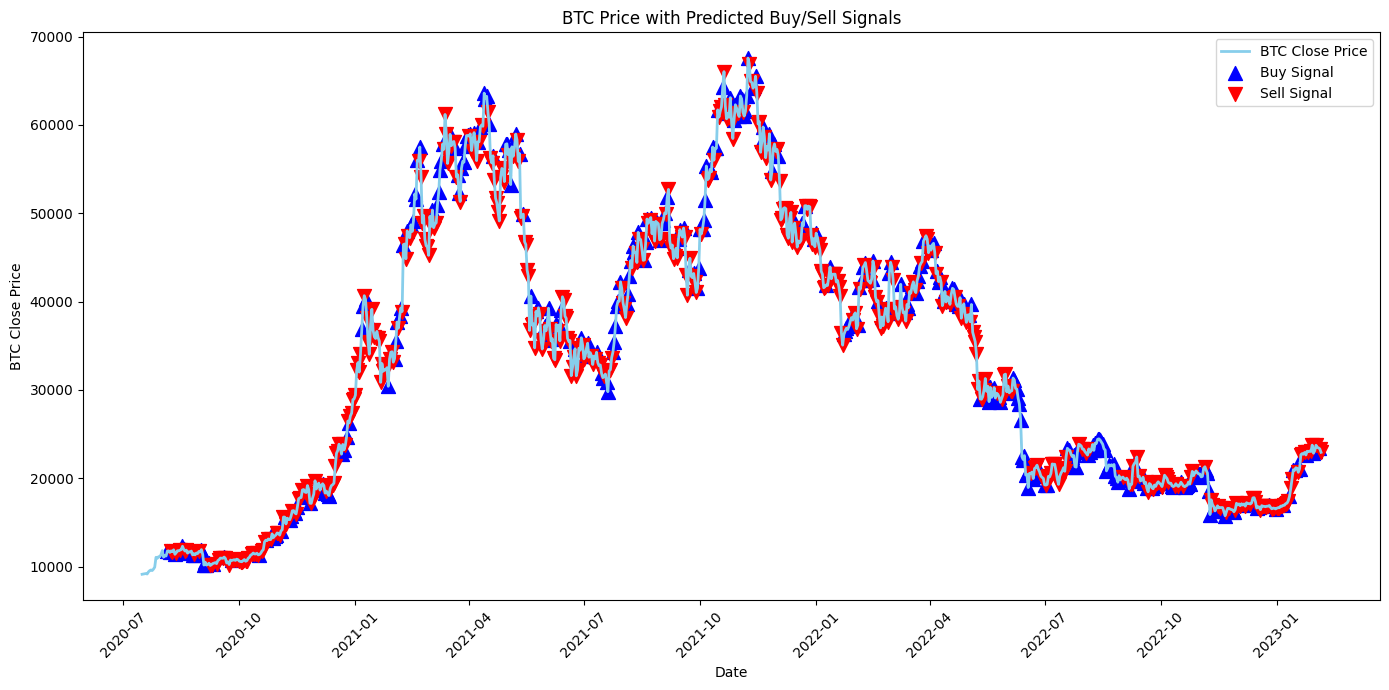

In [59]:

df = pd.read_csv(path)

env = StockMarketEnvironment(df, window_size)


# Function to apply prediction to each row
def predict_signal_for_row(df, index, agents):
    if index < window_size:
        return 1
    last_window_rows = df[index - window_size:index]
    predictions = [agent.act(last_window_rows) for agent in agents]
    # Assuming a simple voting scheme where the majority vote determines the signal
    return max(set(predictions), key=predictions.count)

data_normalized=env.data_normalized

df['predicted_signal'] = [predict_signal_for_row(data_normalized, i, agents) for i in range(len(data_normalized))]

# Ensure datetime is in the correct format
datetime = pd.to_datetime(df['datetime'])



plt.figure(figsize=(14, 7))
plt.plot(datetime, df['close'], label='BTC Close Price', color='skyblue', linewidth=2)

df = df.drop(['datetime','signal'], axis=1)

df['datetime']=datetime
# Adjust the conditions to match the labels
# Highlight buy signals
buy_signals = df[df['predicted_signal'] == 2]  # Assuming 0 represents 'buy'
plt.scatter(buy_signals['datetime'], buy_signals['close'], label='Buy Signal', marker='^', color='blue', alpha=1, s=100)

# Highlight sell signals
sell_signals = df[df['predicted_signal'] == 0]  # Assuming 1 represents 'sell'
plt.scatter(sell_signals['datetime'], sell_signals['close'], label='Sell Signal', marker='v', color='red', alpha=1, s=100)

plt.title('BTC Price with Predicted Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("NicePlot")
plt.show()


In [ ]:
import pickle
def save_agents(agents, filename):
    with open(filename, 'wb') as f:
        pickle.dump(agents, f)


In [ ]:
# Save trained agents to a pickle file
save_agents(agents, 'trained_agents.pkl')